## Import Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

In [2]:
train = pd.read_csv('data_fix_banget.csv')
train.head()

,label,tweet
0,love,!rp hai ele. Maaf ya gua ga romantis. Gua cuma...
1,anger,"""Mka.a jgn ngatain org klu gmau dikatain...jag..."
2,joy,# CONGRATULATIONS # Mengucapkan selamat untuk ...
3,joy,#Allhamdulilah Bertambah usia lagi jagoan keci...
4,sadness,"#Bali, tunggu koko lagi ya. Koko bakal balik l..."


In [3]:
# Shuffle the rows
train = train.sample(frac=1).reset_index(drop=True)

print(train)

         label                                              tweet
0         fear  [USERNAME] aku dikasih tau katanya kalbis nant...
1      sadness  Saya merasa tidak berguna dan tidak berdaya da...
2          joy  Saya biasa menenggak pizza jamur besar dan ken...
3      sadness  Saya pada satu titik menempatkan putra saya di...
4      sadness  Sebenernya teknik lumayan, tapi aneh bgt pas d...
...        ...                                                ...
21128  sadness  Saya mengambil dan pindah ke Republik Ceko sen...
21129  sadness  Ada anak sma habis perpisahan atau semacam wis...
21130    anger  sampe gapaham apa salah aespa ke bts sampe fan...
21131     fear  Ketika kamu merasa seperti kamu harus melawan ...
21132      joy  Saya punya perasaan itu akan menjadi hubungan ...

[21133 rows x 2 columns]


In [4]:
train = train[["label", "tweet"]]
train

,label,tweet
0,fear,[USERNAME] aku dikasih tau katanya kalbis nant...
1,sadness,Saya merasa tidak berguna dan tidak berdaya da...
2,joy,Saya biasa menenggak pizza jamur besar dan ken...
3,sadness,Saya pada satu titik menempatkan putra saya di...
4,sadness,"Sebenernya teknik lumayan, tapi aneh bgt pas d..."
...,...,...
21128,sadness,Saya mengambil dan pindah ke Republik Ceko sen...
21129,sadness,Ada anak sma habis perpisahan atau semacam wis...
21130,anger,sampe gapaham apa salah aespa ke bts sampe fan...
21131,fear,Ketika kamu merasa seperti kamu harus melawan ...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21133 entries, 0 to 21132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   21133 non-null  object
 1   tweet   21133 non-null  object
dtypes: object(2)
memory usage: 330.3+ KB


In [6]:
train.describe()

,label,tweet
count,21133,21133
unique,5,20577
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [7]:
train.describe(include="O")

,label,tweet
count,21133,21133
unique,5,20577
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [8]:
train.groupby(by="label").count()

,tweet
label,
anger,4209
fear,3586
joy,5987
love,1859
sadness,5492


In [9]:
train['num_label'] = train['label'].map({'anger':0, 'fear':1, 'joy':2, 'love':2, 'sadness':3})
train.head()

,label,tweet,num_label
0,fear,[USERNAME] aku dikasih tau katanya kalbis nant...,1
1,sadness,Saya merasa tidak berguna dan tidak berdaya da...,3
2,joy,Saya biasa menenggak pizza jamur besar dan ken...,2
3,sadness,Saya pada satu titik menempatkan putra saya di...,3
4,sadness,"Sebenernya teknik lumayan, tapi aneh bgt pas d...",3


In [10]:
train.groupby(by="num_label").count()

,label,tweet
num_label,,
0,4209,4209
1,3586,3586
2,7846,7846
3,5492,5492


## Data Preprocessing

In [11]:
# !pip install emoji
# !pip install python-crfsuite

In [12]:
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger
excelstopwords = pd.read_excel('stopwords.xlsx')
kamusalay= pd.read_csv("kamusalay.csv")

In [13]:
text = "Woi, hari ini gue sama pacar lagi hangout di mall, abis makan bareng trus jalan-jalan seru-seruan. Gue senyum-senyum sendiri liat dia, rasanya bener-bener bahagia banget deh! Trus kita foto-foto bareng, lumayan buat kenang-kenangan. Pas pulang, gue peluk dia dari belakang, rasanya pengen nggak lepas, kayaknya waktu berhenti sebentar aja. Hari yang indah banget, apalagi sama dia"

In [14]:
def lowercase(review):
    return review.lower() #dari python langsung, bkn dari external library

# hapus URL
def remove_url(review):
    return re.sub(r'http\S+', '', review)

#KAMUS ALAY
def alay(review):
    alay_dic = kamusalay.to_dict()
    alay_dic = dict(zip(kamusalay.iloc[:,0], kamusalay.iloc[:,1]))
    words = review.split()
    for i in range(len(words)):
        word = words[i]
        if word in alay_dic.keys():
            words[i] = alay_dic[word]
    sentence = " ".join(words)
    return sentence

def remove_square_brackets(review):
    # Menghapus teks di dalam kurung siku beserta kurungnya
    return re.sub(r'\[.*?\]', '', review)

# hapus irrelevant char(angka, simbol, tanda baca)
def remove_irrelevant(review):
    return re.sub('[^a-zA-Z\s]', ' ', review)

# hapus spasi lebih dari 1
def remove_space(review):
    review= re.sub(r'\s+', ' ', review)
    review= review.replace('\n', ' ')
    review= review.replace('\\n', ' ')
    review= review.replace('\t', ' ')
    review= review.replace('\\t', ' ')
    review= review.replace('\\u', ' ')
    review= review.replace('\\', ' ')
    return review

# hapus emoji
def remove_emoji(review):
    emoji_pattern= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & dingbat
                           u"\U0001F680-\U0001F6FF"  # transportasi & simbol map
                           u"\U0001F700-\U0001F77F"  # simbol kuno
                           u"\U0001F780-\U0001F7FF"  # simbol kuno tambahan
                           u"\U0001F800-\U0001F8FF"  # simbol tanda batas
                           u"\U0001F900-\U0001F9FF"  # emoticon tambahan
                           u"\U0001FA00-\U0001FA6F"  # simbol musik
                           u"\U0001FA70-\U0001FAFF"  # simbol musik tambahan
                           u"\U00002702-\U000027B0"  # simbol karakter
                           u"\U000024C2-\U0001F251"  # simbol katakter tambahan
                           "]+", flags= re.UNICODE)
    return emoji_pattern.sub(r'', review)


#REMOVING REPEAT CHARACTER
def repeat_char(review):
    review= re.sub('([A-Za-z])\\1{2,}','\\1', review)
    return review


#STOPWORD ENGLISH --> NEED TO FIX
def remove_stopwords(sentence):
    stopwords_list = list(excelstopwords['stopwords'])
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords_list]
    sentence = " ".join(no_words)
    return sentence



In [15]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_url)
   # train['filtering']= train['filtering'].apply(alay)
    train['filtering']= train['filtering'].apply(remove_square_brackets)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    return train

In [16]:
train = df_prep(train)
train = train[train['filtering'] != ""]
train

,label,tweet,num_label,filtering
0,fear,[USERNAME] aku dikasih tau katanya kalbis nant...,1,username dikasih tau kalbis kayak praktikum ny...
1,sadness,Saya merasa tidak berguna dan tidak berdaya da...,3,berguna berdaya hancur
2,joy,Saya biasa menenggak pizza jamur besar dan ken...,2,menenggak pizza jamur kendi bir berbudi luhur
3,sadness,Saya pada satu titik menempatkan putra saya di...,3,titik menempatkan putra penitipan anak menerus...
4,sadness,"Sebenernya teknik lumayan, tapi aneh bgt pas d...",3,teknik lumayan aneh banget pas inter passing s...
...,...,...,...,...
21128,sadness,Saya mengambil dan pindah ke Republik Ceko sen...,3,mengambil pindah republik ceko chris mengirimi...
21129,sadness,Ada anak sma habis perpisahan atau semacam wis...,3,anak habis perpisahan wisuda sekolah foto bare...
21130,anger,sampe gapaham apa salah aespa ke bts sampe fan...,0,gapaham salah aespa bts fan bts alias army suk...
21131,fear,Ketika kamu merasa seperti kamu harus melawan ...,1,melawan takut membesar conqueringgrowingfear


In [17]:
train_split = 0.8
train_size = int(len(train['filtering'])*train_split)
train_size

16906

In [18]:
traindata = train[0:train_size]
valdata = train[train_size:]

In [19]:
traindata

,label,tweet,num_label,filtering
0,fear,[USERNAME] aku dikasih tau katanya kalbis nant...,1,username dikasih tau kalbis kayak praktikum ny...
1,sadness,Saya merasa tidak berguna dan tidak berdaya da...,3,berguna berdaya hancur
2,joy,Saya biasa menenggak pizza jamur besar dan ken...,2,menenggak pizza jamur kendi bir berbudi luhur
3,sadness,Saya pada satu titik menempatkan putra saya di...,3,titik menempatkan putra penitipan anak menerus...
4,sadness,"Sebenernya teknik lumayan, tapi aneh bgt pas d...",3,teknik lumayan aneh banget pas inter passing s...
...,...,...,...,...
16901,fear,Saya merasa sedikit terguncang,1,terguncang
16902,fear,gua masih kaget seriusan..,1,gua kaget seriusan
16903,fear,iya makanya gue takut banget,1,iya gue takut banget
16904,fear,saya tidak merasa panik namun jadi sebaliknya ...,1,panik tidur teddy


In [42]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 500

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')

# Generate the word index dictionary
tokenizer.fit_on_texts(traindata['filtering'])
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(traindata['filtering'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Build Model

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [22]:
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(17000, 64, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
'''

"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Embedding(17000, 64, input_length=max_length),\n    tf.keras.layers.GlobalAveragePooling1D(),\n    tf.keras.layers.Dense(128, activation='relu'),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])\n"

In [23]:
'''
# Build the model
model = tf.keras.Sequential([
    # This is how you need to set the Embedding layer when using pre-trained embeddings
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Print the model summary
model.summary()
'''

'\n# Build the model\nmodel = tf.keras.Sequential([\n    # This is how you need to set the Embedding layer when using pre-trained embeddings\n    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(6, activation = \'relu\'),\n    tf.keras.layers.Dense(1, activation = "sigmoid")\n])\n\n# Print the model summary\nmodel.summary()\n'

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 32, input_length=max_length),
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),  # Reduced number of units
    tf.keras.layers.Dropout(0.2),  # Add dropout layer
    tf.keras.layers.Dense(4, activation='softmax')
])

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 32, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [1]:
from tensorflow.keras.optimizers import Adam
# Define the learning rate
learning_rate = 0.001

# Compile the model with Adam optimizer and specified learning rate

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])


NameError: name 'create_model' is not defined

In [60]:
num_epochs = 20

# Train the model
history = model.fit(training_padded, traindata['num_label'], epochs=num_epochs, validation_data=(validation_padded, valdata['num_label']), verbose=2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [64]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Assuming X_train, y_train, X_val, y_val are your training and validation datasets
history = model.fit(training_padded, traindata['num_label'], epochs=20, batch_size=32, validation_data=(validation_padded, valdata['num_label']))

Epoch 1/20
374/529 [====================>.........] - ETA: 45s - loss: 0.3348 - accuracy: 0.9027

KeyboardInterrupt: 

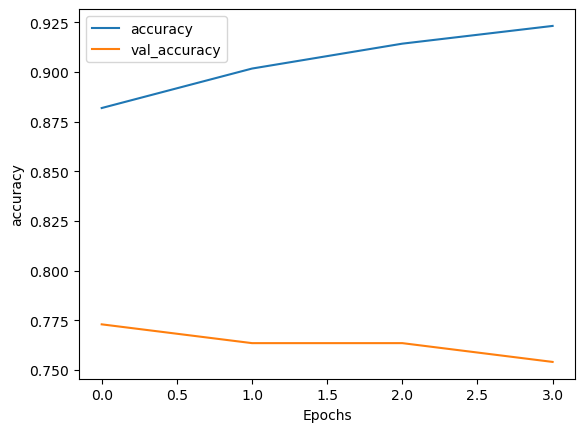

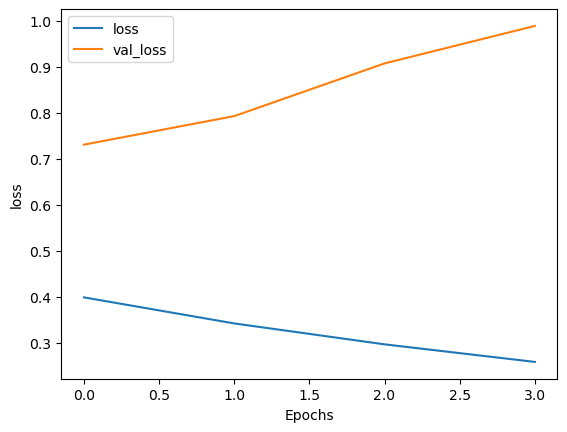

In [65]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Predicting

In [66]:
text = ''"Brosis, hari ini gue lagi on the way ke kampus bareng pacar, tiba-tiba ada anjing yang ngejar-ngejar gue, bikin deg-degan banget, ya Allah! Trus pas nyampe kampus, parkiran full banget, sampe gue sama pacar muter-muter gak dapet-dapet tempat parkir. Akhirnya, kita berdua telat masuk kelas deh! Pas udah masuk, dosen langsung nyerocos ngomel-ngomel gara-gara telat. Capek banget hari ini, apalagi sama pacar."
text

'Brosis, hari ini gue lagi on the way ke kampus bareng pacar, tiba-tiba ada anjing yang ngejar-ngejar gue, bikin deg-degan banget, ya Allah! Trus pas nyampe kampus, parkiran full banget, sampe gue sama pacar muter-muter gak dapet-dapet tempat parkir. Akhirnya, kita berdua telat masuk kelas deh! Pas udah masuk, dosen langsung nyerocos ngomel-ngomel gara-gara telat. Capek banget hari ini, apalagi sama pacar.'

In [67]:
#data test preprocessing

def prep_test(review):
    review = lowercase(review)
    review = remove_url(review)
    review = remove_irrelevant(review)
    review = remove_space(review)
    review = remove_emoji(review)
    review = repeat_char(review)
    review = remove_stopwords(review)
    text = [review]
    inference_sequences = tokenizer.texts_to_sequences(text)
    inference_padded = pad_sequences(inference_sequences, padding=padding_type, maxlen=max_length)
    return inference_padded

In [68]:
test_padded = prep_test(text)
test_padded

array([[   1,    5,  711,  189, 2793, 1351,  407,  280,  276, 3836, 3836,
           5,   40,  702, 1418,    8,    7,   71,    1,   43,    1, 1351,
        3507, 2729,    8, 2649,    5,  280, 2722, 2722, 1465,    1,    1,
        1407,  672, 1043,   79,  136,   48,   43, 1574,   79, 2034,   87,
           1, 2679, 2679,  152,  152, 1043,  810,    8,  280,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [69]:
def prediction(test):
    label = ["anger", "fear", "joy", "sadness"]
    result = model.predict(test)
    index = np.argmax(result)
    hasil = label[index]
    return hasil

In [70]:
prediction(test_padded)

1/1 [==============================] - 2s 2s/step


'anger'

In [71]:
model.predict(test_padded)

1/1 [==============================] - 0s 47ms/step


array([[9.82033968e-01, 5.59152151e-03, 2.85112066e-04, 1.20894285e-02]],
      dtype=float32)

In [72]:
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [73]:
validation_padded

array([[ 159,  323,  909, ...,    0,    0,    0],
       [   3,   28,  466, ...,    0,    0,    0],
       [2011,   70,  144, ...,    0,    0,    0],
       ...,
       [   1,   27,    1, ...,    0,    0,    0],
       [ 396,    4,    1, ...,    0,    0,    0],
       [   6,  181,  632, ...,    0,    0,    0]])

In [74]:
result = model.predict(validation_padded)

133/133 [==============================] - 9s 66ms/step


In [75]:
result

array([[1.5580925e-08, 1.2760960e-07, 9.9994487e-01, 5.4962646e-05],
       [9.5451277e-01, 1.2390492e-02, 2.1515999e-03, 3.0945159e-02],
       [5.4235119e-05, 1.5666430e-04, 9.9516398e-01, 4.6250126e-03],
       ...,
       [1.4460502e-05, 3.0573294e-05, 9.9847633e-01, 1.4786959e-03],
       [8.9037674e-04, 9.9488407e-01, 1.5154277e-03, 2.7101596e-03],
       [2.9904072e-07, 1.8549039e-06, 9.9970239e-01, 2.9539410e-04]],
      dtype=float32)

In [76]:
# Get the index of the maximum probability for each row
predicted_labels = np.argmax(result, axis=1)
predicted_labels

array([2, 0, 2, ..., 2, 1, 2], dtype=int64)

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true contains the true labels and y_pred contains the predicted labels
# Replace y_true and y_pred with your actual data
y_true = np.array(valdata['num_label']) # True labels
y_pred = predicted_labels  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'np' is not defined

In [2]:
# Assuming you have true labels stored in 'true_labels' and predicted labels stored in 'predicted_labels'

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print accuracy
print("Accuracy:", accuracy)


NameError: name 'y_true' is not defined

In [97]:
model.pred()

AttributeError: 'Sequential' object has no attribute 'pred'

In [86]:
# Generate and pad the validation sequences
all_sequences = tokenizer.texts_to_sequences(train['filtering'])
all_padded = pad_sequences(all_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)





In [87]:
hasil = model.predict(all_padded)
hasil

661/661 [==============================] - 46s 69ms/step


array([[2.6782489e-04, 9.9903399e-01, 9.5507108e-05, 6.0260203e-04],
       [1.5154089e-03, 1.8960432e-03, 2.3063920e-03, 9.9428213e-01],
       [1.0464153e-06, 3.8747753e-06, 9.9960274e-01, 3.9243384e-04],
       ...,
       [1.4460502e-05, 3.0573294e-05, 9.9847633e-01, 1.4786959e-03],
       [8.9037674e-04, 9.9488407e-01, 1.5154277e-03, 2.7101596e-03],
       [2.9904072e-07, 1.8549039e-06, 9.9970239e-01, 2.9539410e-04]],
      dtype=float32)

In [88]:
# Get the index of the maximum probability for each row
predicted_labels_all = np.argmax(hasil, axis=1)
predicted_labels_all

array([1, 3, 2, ..., 2, 1, 2], dtype=int64)

In [89]:
datas = train[['filtering',"num_label"]]

In [105]:
label_pred = pd.DataFrame(predicted_labels_all)
label_pred

NameError: name 'df1' is not defined

In [107]:
merged_df = pd.concat([datas, label_pred], axis=1)
merged_df

,filtering,num_label,0
0,username dikasih tau kalbis kayak praktikum ny...,1,1
1,berguna berdaya hancur,3,3
2,menenggak pizza jamur kendi bir berbudi luhur,2,2
3,titik menempatkan putra penitipan anak menerus...,3,3
4,teknik lumayan aneh banget pas inter passing s...,3,3
...,...,...,...
21128,mengambil pindah republik ceko chris mengirimi...,3,3
21129,anak habis perpisahan wisuda sekolah foto bare...,3,3
21130,gapaham salah aespa bts fan bts alias army suk...,0,2
21131,melawan takut membesar conqueringgrowingfear,1,1


In [113]:
aw = merged_df[merged_df['num_label']!=merged_df[0]]
aw.to_csv("dataxx.csv",index=False)

In [108]:
# Example DataFrame and array
# datas = pd.DataFrame({
#     'filtering': [...],
#     'num_label': [...]
# })

# hasil = model.predict(all_padded)

# Convert hasil to a pandas Series (if it's not already in the correct format)
hasil_series = pd.Series(predicted_labels_all, name='hasil')

# Concatenate the DataFrame and the Series
datas_with_hasil = pd.concat([datas.reset_index(drop=True), hasil_series], axis=1)

# Now, datas_with_hasil contains the original datas with an additional column 'hasil'
print(datas_with_hasil.head())


                                           filtering  num_label  hasil
0  username dikasih tau kalbis kayak praktikum ny...          1      1
1                             berguna berdaya hancur          3      3
2      menenggak pizza jamur kendi bir berbudi luhur          2      2
3  titik menempatkan putra penitipan anak menerus...          3      3
4  teknik lumayan aneh banget pas inter passing s...          3      3


In [85]:
datas_with_hasil

,filtering,num_label,hasil
0,username dikasih tau kalbis kayak praktikum ny...,1,2.0
1,berguna berdaya hancur,3,0.0
2,menenggak pizza jamur kendi bir berbudi luhur,2,2.0
3,titik menempatkan putra penitipan anak menerus...,3,2.0
4,teknik lumayan aneh banget pas inter passing s...,3,0.0
...,...,...,...
21128,mengambil pindah republik ceko chris mengirimi...,3,NaN
21129,anak habis perpisahan wisuda sekolah foto bare...,3,NaN
21130,gapaham salah aespa bts fan bts alias army suk...,0,NaN
21131,melawan takut membesar conqueringgrowingfear,1,NaN
